## 2 - Criação do Modelo

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

#### Importando os dados de imposto arrecadado 

In [3]:
df_declaracao_servico = pd.read_csv('../Datasets/iss_declaracao_anonimizado.csv', sep=';')
df_declaracao_servico

,row,id_empresa,competencia,tipo,imposto
0,1,1,201106,Prestado,"127,24"
1,2,1,201907,Prestado,"587,1348"
2,3,1,201112,Prestado,"160,62"
3,4,1,201704,Prestado,"312,94"
4,5,1,202304,Prestado,"122,54"
...,...,...,...,...,...
281430,281431,6365,202305,Prestado,90
281431,281432,6366,202304,Prestado,"135,96"
281432,281433,6367,202305,Prestado,260
281433,281434,6368,202305,Tomado,20


##### Realizando os tratamentos nos dados

###### Convertendo o valor de imposto para o tipo float

In [4]:
df_declaracao_servico['imposto'] = df_declaracao_servico['imposto'].str.replace(',', '.').astype(float).round(2)


###### Convertendo a competência para uma data

In [5]:
df_declaracao_servico['competencia'] = df_declaracao_servico['competencia'].astype(str) + '01'
df_declaracao_servico['competencia'] = pd.to_datetime(df_declaracao_servico['competencia'], format='%Y%m%d')

###### Filtrando os dados para apenas os serviços prestados, que são o foco do dataset

In [6]:
df_servicos_prestados = df_declaracao_servico[df_declaracao_servico['tipo'] == 'Prestado']
df_servicos_prestados = df_servicos_prestados.drop(columns=['tipo', 'row'])


###### Criando dataset de ISS por mês

In [7]:
df_iss_competencia = df_servicos_prestados.drop(columns=['id_empresa']).groupby(['competencia']).sum(['imposto'])
df_iss_competencia = df_iss_competencia.reset_index()
df_iss_competencia

,competencia,imposto
0,2005-01-01,10.75
1,2005-07-01,185.85
2,2005-10-01,3.00
3,2005-11-01,28.19
4,2005-12-01,31.24
...,...,...
209,2023-01-01,2396203.84
210,2023-02-01,2608697.45
211,2023-03-01,2914846.69
212,2023-04-01,1084466.38


##### Filtrando o período dos dados
###### Foi optado o período de **01/2008** até **03/2003** pois este intervalo apresenta dados com menos alterações do ambiente de qualidade
###### Além disso, os dados das declarações mais recentes não estavam completos

In [8]:
df_iss_competencia = df_iss_competencia[(df_iss_competencia['competencia'] <= '2023-03-01') & (df_iss_competencia['competencia'] >= '2008-01-01')]
df_iss_competencia

,competencia,imposto
29,2008-01-01,193283.34
30,2008-02-01,211406.84
31,2008-03-01,220740.14
32,2008-04-01,254053.26
33,2008-05-01,367762.04
...,...,...
207,2022-11-01,2735806.00
208,2022-12-01,2800769.04
209,2023-01-01,2396203.84
210,2023-02-01,2608697.45


###### Definindo os dados para treinar o modelo

In [9]:
data = df_iss_competencia.set_index('competencia')
data

,imposto
competencia,
2008-01-01,193283.34
2008-02-01,211406.84
2008-03-01,220740.14
2008-04-01,254053.26
2008-05-01,367762.04
...,...
2022-11-01,2735806.00
2022-12-01,2800769.04
2023-01-01,2396203.84


#### Fazendo a reescala dos dados 

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))
data['imposto'] = scaler.fit_transform(data)
data

,imposto
competencia,
2008-01-01,0.000000
2008-02-01,0.006659
2008-03-01,0.010089
2008-04-01,0.022329
2008-05-01,0.064110
...,...
2022-11-01,0.934214
2022-12-01,0.958084
2023-01-01,0.809432


#### Definindo dados de treino e teste

In [11]:
train = data.iloc[:len(data)-6]
test = data.iloc[len(data)-6:]

start = len(train)
end = len(train) + len(test) -1


#### Verificando informações da sazonalidade

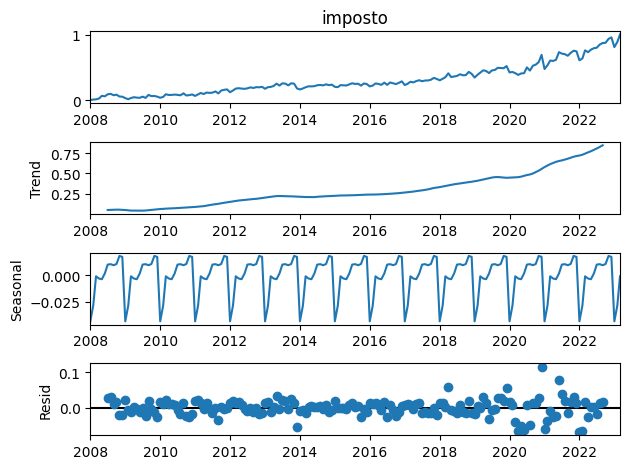

In [12]:
ssn = seasonal_decompose(data['imposto'], model='add')
ssn.plot();

### **Criando o modelo**

##### Executando o auto_arima

In [13]:
auto_arima_results= auto_arima(train['imposto'], 
           start_p=0,
           start_q=0,
           max_p=10,
           max_q=10,          
           m=12,              
           d=None,           
           seasonal=True,  
           start_P=0, 
           D=None,  
           trace=True,
           error_action='ignore',  
           suppress_warnings=True, 
           stepwise=True)

auto_arima_results.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-694.966, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-664.030, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-717.484, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-715.753, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-662.786, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-675.141, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-716.161, Time=0.75 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-720.417, Time=0.35 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-710.243, Time=0.13 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-718.733, Time=0.97 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-721.310, Time=0.86 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-711.950, Time=0.50 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=-721.959, Time=0.96 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=-700.895, Time=0.85 sec
 ARIMA(2,1,0)(2,0,2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  177
Model:             SARIMAX(2, 1, 0)x(1, 0, [1, 2], 12)   Log Likelihood                 369.546
Date:                                 Thu, 18 May 2023   AIC                           -727.092
Time:                                         23:03:31   BIC                           -708.070
Sample:                                     01-01-2008   HQIC                          -719.377
                                          - 09-01-2022                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3854      0.055     -6.957      0.000      -0.494      -0.277
ar.L2         -0.1284      0.062     -2.081      0.037      -0.249      -0.007
ar.S.L12       0.9556      0.083     11.532      0.000       0.793       1.118
ma.S.L12      -0.5664      0.131     -4.340      0.000      -0.822      -0.311
ma.S.L24      -0.1971      0.111     -1.774      0.076      -0.415       0.021
sigma2         0.0008   6.51e-05     12.882      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):               120.00
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               6.33   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Utilizando o modelo SARIMAX

In [14]:
sarimax_model= SARIMAX(train["imposto"], order=(2, 1, 0), seasonal_order=(1, 0, [1, 2], 12))

sarimax_model_fit = sarimax_model.fit()


/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.03525D+00    |proj g|=  6.35239D+00

At iterate    5    f= -2.04989D+00    |proj g|=  5.71847D-01

At iterate   10    f= -2.06393D+00    |proj g|=  4.00784D+00

At iterate   15    f= -2.07170D+00    |proj g|=  5.86395D-01

At iterate   20    f= -2.07210D+00    |proj g|=  8.58483D-01

At iterate   25    f= -2.07367D+00    |proj g|=  1.50632D-01

At iterate   30    f= -2.07411D+00    |proj g|=  1.07671D+00

At iterate   35    f= -2.08334D+00    |proj g|=  4.06087D-01

At iterate   40    f= -2.08454D+00    |proj g|=  4.19567D-01

At iterate   45    f= -2.08763D+00    |proj g|=  5.52630D-01

At iterate   50    f= -2.08783D+00    |proj g|=  3.91100D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/usr/local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### Realizando previsões

###### Valor de ISS para os próximos 6 meses

<AxesSubplot: title={'center': 'Real vs Predições - Dataset de teste'}, xlabel='competencia'>

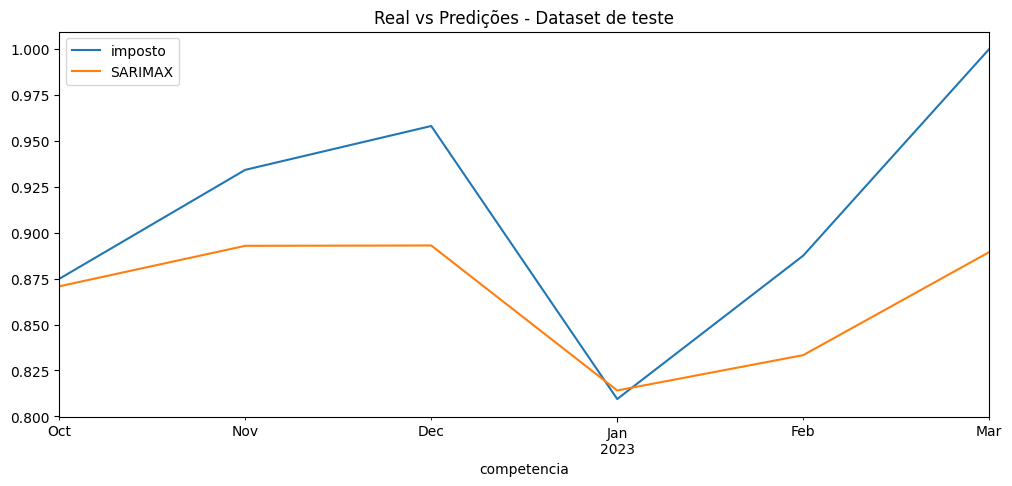

In [15]:
pred_test = sarimax_model_fit.predict(start=start, end=end, dynamic=False).rename("SARIMAX")

test["imposto"].plot(figsize=(12,5), title= "Real vs Predições - Dataset de teste", legend=True)
pred_test.plot(legend=True)

<AxesSubplot: title={'center': 'Real vs Predições - Visão geral'}, xlabel='competencia'>

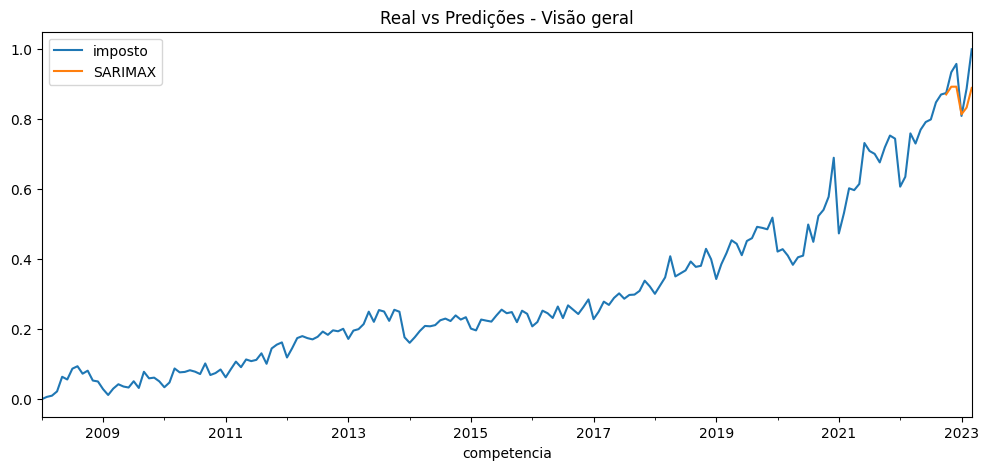

In [16]:
data["imposto"].plot(figsize=(12,5), title= "Real vs Predições - Visão geral", legend=True)
pred_test.plot(legend=True)

###### Exibindo previsão e dados a partir de 03/2020

<AxesSubplot: title={'center': 'Real vs Predições'}, xlabel='competencia'>

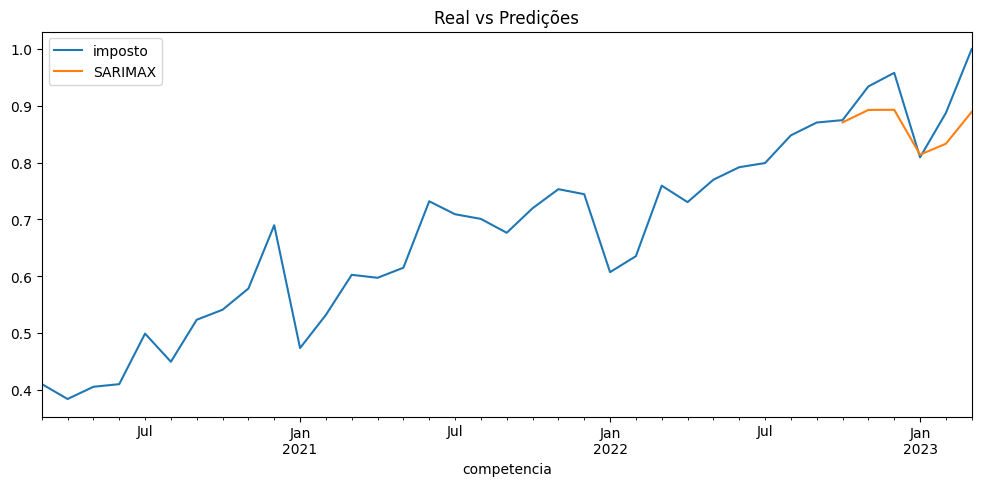

In [19]:
data.iloc[len(data)-37:]["imposto"].plot(figsize=(12,5), title= "Real vs Predições", legend=True)
pred_test.plot(legend=True)

###### Valor previsto no dataset completo

<AxesSubplot: title={'center': 'Real vs Predições - Dataset completo'}, xlabel='competencia'>

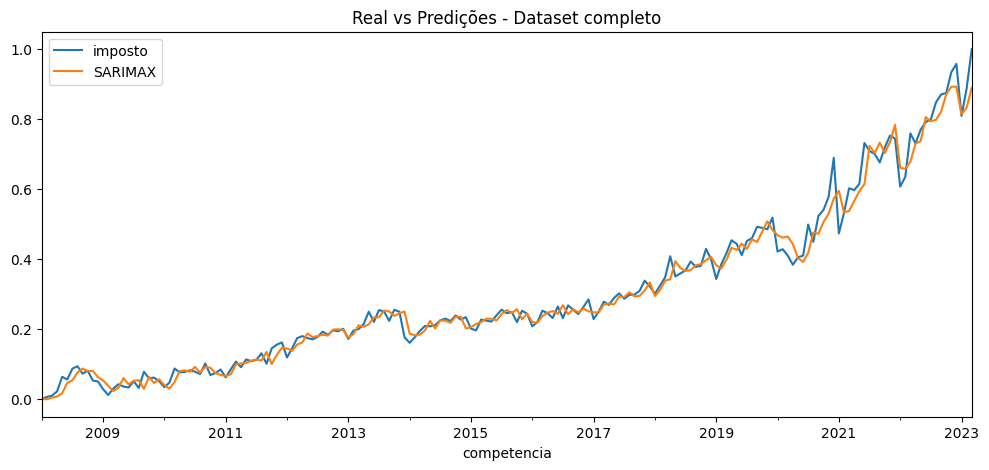

In [23]:
pred_full_dataset = sarimax_model_fit.predict(start=0, end=end, dynamic=False, typ="levels").rename("SARIMAX")

data["imposto"].plot(figsize=(12,5), title= "Real vs Predições - Dataset completo", legend=True)
pred_full_dataset.plot(legend=True)

## 3 - Avaliação do Modelo

In [24]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test["imposto"], pred_test, squared=True)
rmse = mean_squared_error(test["imposto"], pred_test, squared=False)

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")

RMSE: 0.05935891773410078
MSE: 0.0035234811145637437


###### **Atenção**: os dados estão escalados, então isto pode ter afetado o resultado das métricas